# <center> Starting a Coffee Business in Toronto </center>
### <center> Analysis about the Coffee Business in Toronto Based on the Yelp Dataset. </center>
### <center>Haiyue Yang Feb 2020 </center>

## Introduction

Considering you would like to start a coffee business business, but you do not have any experience. What are you going to do? Probably, you would ask a friend who owns a coffee shops for experience. But the experience from a single franchises might not be enough, so let's take an insight into the Yelp dataset to find out the mystery of starting a popular coffee shop.

In this report, we would use the data from the yelp dataset (For academic use only. Not allowed for commercial use)(**Question 1.1**) to analyse the businesses and reviews overall and in Toronto, focused mainly on coffee businesses, and especially on the two coffee giants Tim Horton's and Starbucks, and investigate how to start a coffee business in Toronto successfully.

## About the data (**Question 1.2**)
### `business`:
- `business_id`: the unique id for each business
- `name`: the name of the franchise
- `address`: the address of the business
- `city`: the city the business in
- `state`: the state the business in
- `postal_code`: the postal code of the business
- `latitude`: the latitude of the location of the business
- `longitude`: the longitude of the location of the business
- `stars`: the stars rating of the business
- `review_count`: the total number of reviews of the business
- `is_open`: whether the business is open
- `attributes`: the information of certain attributes of the business
- `categories`: the categories that the business belongs to
- `hours`: the openning hours of the business
### `review`:
- `review_id`: the unique id for the review
- `user_id`: the unique id for the user who wrote the review
- `business_id`: the unique id for the business the reviews for
- `stars`: the rating the reviewers gave
- `useful`, `funny`, `cool`: the rate of different characteristics
- `text`: the text of the review
- `date`: the date of the reivew

## Data Cleaning
### Business Overall

In [1]:
# import modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import json
import math
import descartes
import fuzzywuzzy
import pyecharts
import folium

from fuzzywuzzy import process
from pyecharts import options as opts
from pyecharts.charts import Page, WordCloud, Boxplot, Grid
from pyecharts.globals import SymbolType
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import radians, cos, sin, asin, sqrt

In [23]:
import warnings 
warnings.filterwarnings('ignore') 

**First**, we loaded the data on **business** from the yelp dataset into the dataframe `df`.

**Then**, we used the function `fuzzywuzzy` to find the similarity of city name pairs, unified the city name pairs with either the ratio, partial_ratio, or the token_set_ratio larger than 90, and stored the unified expressions in a new column `modifed_city`.

For the rest of the cities which cannot match to others, we simply copy their original expressions in `city` to `modified_city`.

In [2]:
# import business data
df = pd.read_json("business.json", lines = True)

In [3]:
# the original dataframe
df = df[df.city!=''].reset_index().drop(columns='index')
df['modify'] = False
df['modified_city'] = 'NaN'

In [4]:
# the unique city name list
df_city = df.groupby('city').count().reset_index()
df_city = df_city[['city', 'name']]
df_city.columns = ['city', 'num']
df_city = df_city.sort_values('num', ascending=False)

In [5]:
# function to standarize the city names
def modify(scorer):
    for i in range(0, len(df_city.city)):
        matches = fuzzywuzzy.process.extract(df_city.city[i], df_city.city.unique(), limit = 20, scorer=scorer)
        close_matches = [match[0] for match in matches if match[1] >= 90]
        rows = df['city'].isin(close_matches)
        if (len(close_matches)>1):
            df.loc[rows, 'modified_city'] = df_city.city[i]

modify(fuzzywuzzy.fuzz.ratio)
modify(fuzzywuzzy.fuzz.partial_ratio)
modify(fuzzywuzzy.fuzz.token_set_ratio)

In [6]:
# the list of cities cannot match to others
unchanged = df[df.modified_city=='NaN'].city.unique()
for city in unchanged:
    rows = df['city']==city
    df.loc[rows, 'modified_city'] = city

In [7]:
print('There are', len(df.modified_city.unique()), 'cities in the yelp dataset in total.')

There are 778 cities in the yelp dataset in total.


We drew a wordcloud containing the cities of top 100 number of businesses in the yelp data. It could gives us a glimpse into the popular cities that the yelp dataset encompasses. (**Question 2.1** more discussions later).

In [9]:
# extract the top-20 cities
modified_city = df.groupby('modified_city').count().reset_index()
modified_city = modified_city[['modified_city', 'city']]
modified_city.columns = ['city', 'num']
modified_city = modified_city.sort_values('num', ascending=False).reset_index().drop(columns = 'index')

# city name word cloud
city = []
for i in range(0, 100):
    log = math.log(modified_city.num[i])
    city.append((modified_city.city[i], log))
cloud = (
    WordCloud()
    .add("", city, word_size_range=[10, 50])
    .set_global_opts(title_opts=opts.TitleOpts(title="Cities encompass"))
    )
cloud.render_notebook()

**Next**, we examined whether the business has bike parking spaces, by examining the dictionaries stored in the column `attributes`, and saved it in a new column `BikeParking`.

**After that**, according to the information provided on the wikipedia, the postal codes in the Great Toronto Area start with M and L, so we decided whether the businesses is in the GTA or not, by choosing the businesses with `postal_code` starting with M or L, and saved it in a new column `GTA`

This is a glimpse of the data.

In [10]:
# extract information about BikeParking and GTA
df['BikeParking'] = False
df['GTA'] = False
df = df.drop(columns = 'modify')
for i in range(0, len(df)):
    if (df.attributes[i]!= None) and ('BikeParking' in df.attributes[i]) and (df.attributes[i]['BikeParking'] == 'True'):
        df.loc[i, 'BikeParking'] = True
    if df.postal_code[i]!='' and (df.postal_code[i][0]=='M' or df.postal_code[i][0]=='L'):
        df.loc[i, 'GTA'] = True

In [11]:
df.to_csv('./cleaned_business.csv', index=False)

In [117]:
GTA_reviews.head()

review_id                 user_id             business_id  \
6   G7XHMxG0bx9oBJNECG4IFg  jlu4CztcSxrKx56ba1a5AQ  3fw2X5bZYeW9xCz_zGhOHg   
14  JVcjMhlavKKn3UIt9p9OXA  TpyOT5E16YASd7EWjLQlrw  AakkkTuGZA2KBodKi2_u8A   
15  svK3nBU7Rk8VfGorlrN52A  NJlxGtouq06hhC7sS2ECYw  YvrylyuWgbP90RgMqZQVnQ   
19  4bUyL7lzoWzDZaJETAKREg  _N7Ndn29bpll_961oPeEfw  y-Iw6dZflNix4BdwIyTNGA   
34  E6B-2U2sGG3xgmnNWZAEew  DbccYu3OppWKl21OanZnTg  YSUcHqlKMPHHJ_cTrqtNrA   

    stars  useful  funny  cool  \
6     3.0       5      4     5   
14    1.0       1      1     0   
15    5.0       0      0     0   
19    3.0       0      0     0   
34    1.0       0      0     0   

                                                 text                 date  \
6   Tracy dessert had a big name in Hong Kong and ...  2016-05-07 01:21:02   
14  I cannot believe how things have changed in 3 ...  2012-07-16 00:37:14   
15  You can't really find anything wrong with this...  2017-04-07 21:27:49   
19  Good selection of classes of beers and mains. ...  2014-06-27 21:19:23   
34  Came here on a Thursday night at 6:30 p.m. My ...  2017-12-29 13:55:19   

     GTA    tim   star  
6   True  False  False  
14  True  False  False  
15  True  False  False  
19  True  False  False  
34  True  False  False

### Business in the GTA
We extracted data in the Great Toronto Area (GTA) to a new dataframe `GTA` using the indicator stored in the column `GTA` already, and saved it for later use.

This is a glimpse of the new dataframe.

In [13]:
# extract data in GTA
GTA = df[df.GTA==True]
GTA = GTA.reset_index().drop(columns = 'index')

In [14]:
GTA.to_csv('./gta_business.csv', index=False)

### Reviews in the GTA
**First**, we loaded the data on **review** from the yelp dataset into the dataframe `reviews`.

**After that**,we extracted the reviews in the GTA area to the dataframe `GTA_reviews` by matching the `business_id` in the dataframe `review` to the `business_id` in the dataframe `GTA`.

This is a glimpse of the dataframe extracted.

In [16]:
review = []
for line in open('review.json', 'r'):
    review.append(json.loads(line))
reviews = pd.DataFrame(review)
reviews['GTA'] = False
rows = reviews['business_id'].isin(GTA.business_id)
reviews.loc[rows, 'GTA'] = True

In [17]:
GTA_reviews = reviews[reviews.GTA == True]

## Why Start a Coffee Business in Toronto?
### Why Start a Business in Toronto?

In order to benefit from the business, before starting the business, we have to make sure we make the right decision, so we would like to investigate why it is rational to start a coffee business in Toronto.

We grouped the overall dataframe by the modified city name `modified_city` and counted the total number of business in each city. The following barplot gives information about the cities with top 10 number of business.

In [18]:
modified_city = df.groupby('modified_city').count().reset_index()
modified_city = modified_city[['modified_city', 'city']]
modified_city.columns = ['city', 'num']
modified_city = modified_city.sort_values('num', ascending=False).reset_index().drop(columns = 'index')
# modified_city.head(10)

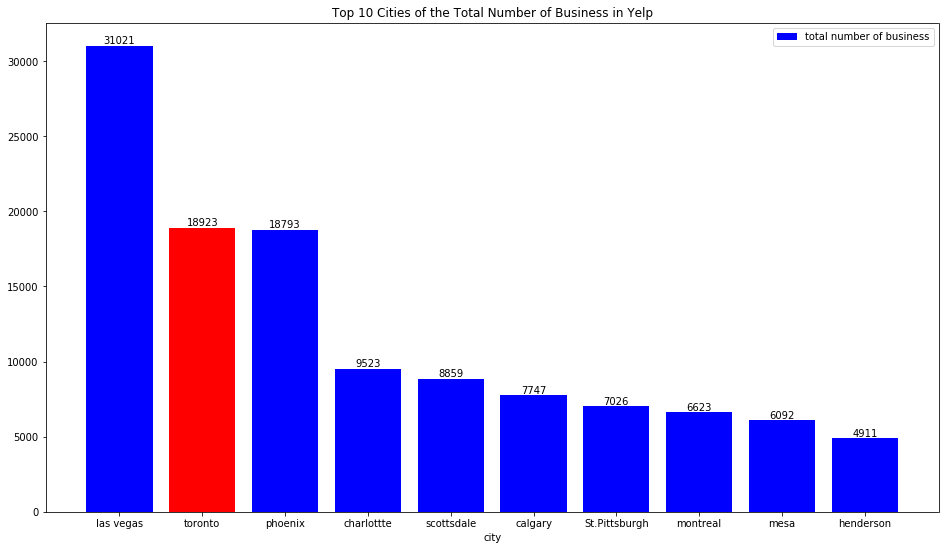

In [19]:
df_city = pd.DataFrame(city).head(10)
df_city.columns = ['city', 'log']
cities = df_city.city
log = modified_city.head(10).num

colors = ['b', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
x = np.arange(len(df_city))

plt.figure(figsize=(16, 9))
plt.bar(x, log, color=colors, label='total number of business', tick_label=cities)
plt.legend(loc='best')
plt.xlabel('city')
plt.title('Top 10 Cities of the Total Number of Business in Yelp')

for a,b in zip(x, log):
    plt.text(a, b+0.1, b, ha='center', va='bottom')

plt.show()

Unsurprisingly, **Las Vegas, the city famous for industries in tourism, gaming and conventions, which in turn feed the retail and restaurant industries, are the city with the largest amount of business on Yelp**. However, we noticed that our city, **Toronto, as the biggest city in Canada, has the second large amount of business.** Thus, if you do not want to move away from your home here and pay the extremely high rent in Las Vegas, Toronto might be a good choice to start a business. (**Question 2.1**)

### Why Start a Coffee Business?

In addition to the location of the new business, our city Toronto, is flourishing in various industries, so we also have lots of choices considering the category of our business. Therefore, let's take a deeper insight into the business in the Great Toronto Area (GTA).

**Firstly**, we noticed that there might be several different expressions of the same franchises. For instance, the coffee shop Tim Horton's is sometiems expressed as Tim Hortons or simply Tim Horton. Thus, in order to find a more acurate number of businesses of top franchises, we use the function `fuzzywuzzy` to find business names that match to the franchises with top 50 largest number of businesses in GTA. If the match ratio is larger than 90, we assumed they are different expression of the same franchise name and standardized them. The standarized expressions are stored in a new column `modified_name`

Next, we grouped the `GTA` dataframe by the column `modified_name`, counted the total number of businesses of each franchise in the GTA, and visualized some of them.

The following plots give the information about the top 10 franchises with the largest amount of business in the GTA.

In [20]:
# standarize the name of the top-50 franchises
GTA['modified_name'] = 'NaN'
GTA_name = []
for name in GTA.groupby('name').count().sort_values('business_id', ascending = False).head(50).index:
    GTA_name.append(name)
i = 0
while i < len(GTA_name):
    matches = fuzzywuzzy.process.extract(GTA_name[i], GTA_name, limit=5, scorer=fuzzywuzzy.fuzz.ratio)
    close_matches = [match[0] for match in matches if match[1] >= 90]
    rows = GTA['name'].isin(close_matches)
    GTA.loc[rows, 'modified_name'] = GTA_name[i]
    for match in close_matches:
        GTA_name.remove(match)
    i += 1
for i in range(0, len(GTA)):
    if GTA.modified_name[i] == 'NaN':
        GTA.loc[i, 'modified_name'] = GTA.name[i]

In [21]:
GTA_name_count = GTA.groupby('modified_name').count()[['business_id']].sort_values('business_id', ascending = False)
GTA_name_count.columns = ['num']

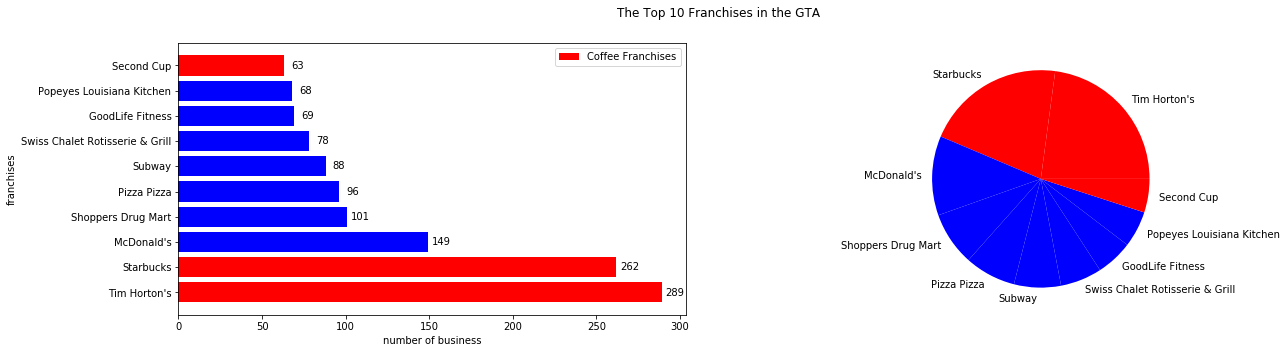

In [22]:
colors0 = ['r', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r']
figure,ax=plt.subplots(1,2, figsize=(20,5))
x = np.arange(10)

ax[0].barh(x, GTA_name_count.head(10).num, color=colors0, label='Coffee Franchises', tick_label=GTA_name_count.head(10).index)
ax[0].legend()
ax[0].set_ylabel('franchises')
ax[0].set_xlabel('number of business')

for a, b in zip(x, GTA_name_count.head(10).num):
    ax[0].text(b+8, a, b, ha='center', va='center')

ax[1].pie(GTA_name_count.head(10).num, labels = GTA_name_count.head(10).index, colors = colors0)

figure.suptitle('The Top 10 Franchises in the GTA')

plt.show()

In the both of the plots above, coffee franchises are marked red.

We were surprised to discover that **the two largest franchises in the GTA are all coffee franchises, Tim Hortons and Starbucks**, and **the number of business of these two franchises are also much large than that of the third largest franchises, McDonald's.** 

Morover, **3 of the top 10 franchises in the GTA are coffee franchises and the number of business of these 3 coffee franchises, Tim Hortons, Starbucks, and Second Cup, account for nearly half of the business of the top 10 franchises**, showing the success of these coffee giants. (**Question 3.2**)

However, the success of these three coffee giants not necessarily means the flourishing of the whole coffee industry. Thus, we continued to investigate whether coffee is a popular category in whole in the GTA.

**Secondly**, we extracted the columns `categories` and `attributes` in the dataframe `df` and `GTA`, stored them in new dataframes `category` and ` GTA_cate` respectively, and split each category of a business to a separate row. Then, we grouped by new dataframes `category` and `GTA_cate` by the splitted `categories`, counted the total number of each category overall and in GTA respectively, calculated the percentage of each category, and stored them in new dataframes `category_count` and `GTA_cate_count`. Next, we created a new dataframe `top` containing the information about the top 10 categories in the GTA. The column `Overall` stores the percentage of each category in the overall dataset, and the column `GTA` stores the percentage of each category in the GTA.

After that, using the `top` dataframe, we drew a bar plot showing the top 10 most frequent categories in the GTA and the percentage of businesses in each category overall and in GTA.

In [24]:
# extract information about categories overall
category = df[['categories', 'attributes']]
category = category.drop('categories', axis=1).join(
    category['categories'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('categories'))
category['attributes'] = 1

# find the top-10  overall
category_count = category.groupby('categories').count()
category_count.columns = ['num']
category_count['percent'] = 100 * category_count['num'] / len(category)
category_count = category_count.sort_values('num', ascending=False)

# extract the information about categories in GTA
GTA_cate = GTA[['categories']]
GTA_cate = GTA_cate.drop('categories', axis=1).join(
    GTA_cate['categories'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('categories')).reset_index()
GTA_cate_count = GTA_cate.groupby('categories').count().sort_values('index', ascending=False)
GTA_cate_count.columns = ['num']
GTA_cate_count['percent'] = 100 * GTA_cate_count.num / len(GTA_cate)

In [25]:
top = pd.DataFrame(GTA_cate_count.head(10).index)
top.columns = ['categories']
top['Overall'] = 0
top['GTA'] = 0
for i in range(0, len(top)):
    top.loc[i, 'Overall'] = category_count.loc[top['categories'][i]].percent
    top.loc[i, 'GTA'] = GTA_cate_count.loc[top['categories'][i]].percent
top = top.sort_values('GTA', ascending = False)

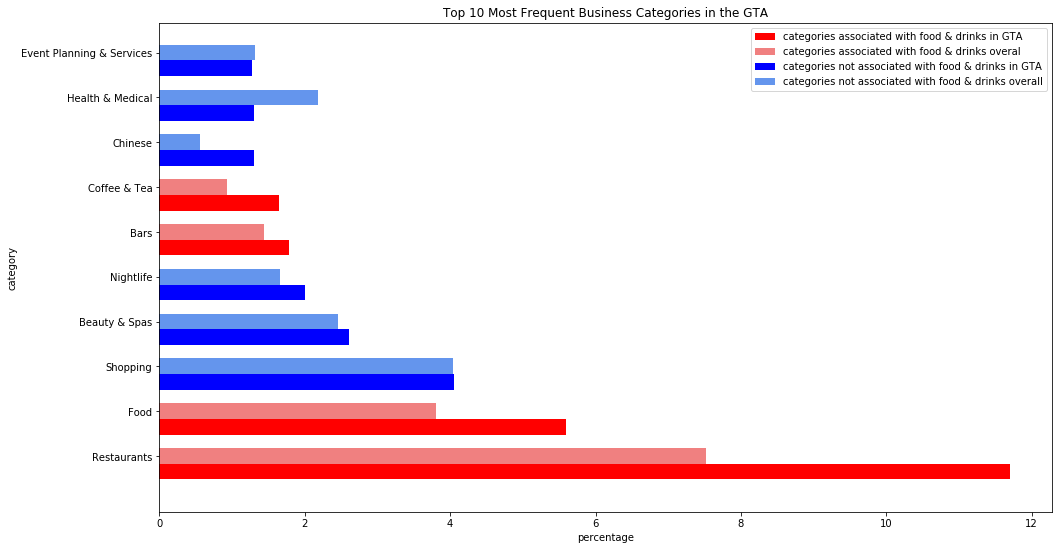

In [44]:
cate_gta = top.categories
percent_gta = top.GTA
percent_all = top.Overall

colors0 = ['r', 'r', 'b', 'b', 'b', 'r', 'r', 'b', 'b', 'b']
colors1 = ['lightcoral', 'lightcoral', 'cornflowerblue', 'cornflowerblue', 'cornflowerblue', 'lightcoral', 'lightcoral', 'cornflowerblue',
           'cornflowerblue', 'cornflowerblue']
height = 0.35
x = np.arange(len(GTA_cate_count.head(10)))

plt.figure(figsize=(16, 9))
plt.barh(x, percent_gta, color=colors0, height=height, label='categories associated with food & drinks in GTA')
plt.barh(x+height, percent_all, color=colors1, height=height, label='categories associated with food & drinks overal', tick_label=cate_gta)
plt.barh(x, [0,0,0,0,0,0,0,0,0,0], color=['b'], label='categories not associated with food & drinks in GTA')
plt.barh(x, [0,0,0,0,0,0,0,0,0,0], color=['cornflowerblue'], label='categories not associated with food & drinks overall')
plt.legend(loc='best')
plt.ylabel('category')
plt.xlabel('percentage')
plt.title("Top 10 Most Frequent Business Categories in the GTA")

plt.show()

The graph above shows the top 10 most frequent business category in the GTA and there percentage in the GTA and overall.

It is obvious that, **the percentage of the four categories associated with food and drinks: restaurants, food, bars, and coffee & tea, in the GTA are all high than that overall.** This fact tells us probably Toronto is a proper place for business about food and drinks. (**Question 3.1**, more discussions below)

Nevertheless, we have only analysed the information aobut the most frequent catgories in the GTA. What about compare them to the most frequently categories overall?

**Thirdly**, we drew pie charts for both the top 10 most frequent categories in the GTA and overall.

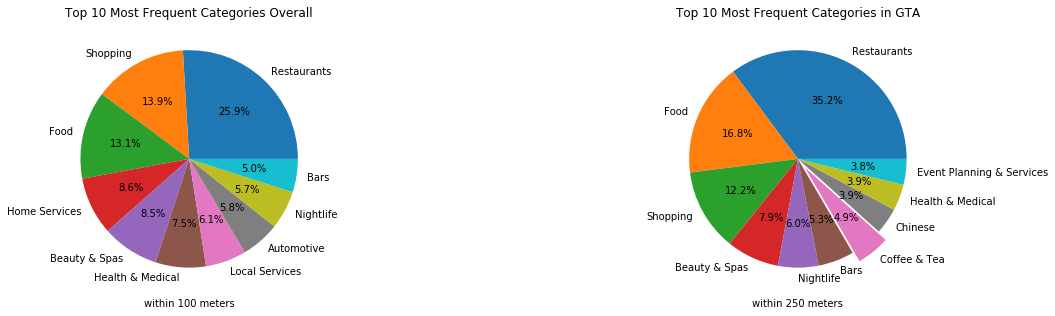

In [27]:
figure,axes=plt.subplots(nrows=1,ncols=2,figsize=(20,5))

pie1=axes[0].pie(category_count.head(10).num, autopct='%1.1f%%', labels=category_count.head(10).index)
pie2=axes[1].pie(GTA_cate_count.head(10).num, autopct='%1.1f%%', explode=[0,0,0,0,0,0,0.1,0,0,0], labels=GTA_cate_count.head(10).index)
axes[0].set_xlabel('within 100 meters')
axes[1].set_xlabel('within 250 meters')
axes[0].set_title('Top 10 Most Frequent Categories Overall')
axes[1].set_title('Top 10 Most Frequent Categories in GTA')

plt.show()

The pies above demonstrate that **restaurants, shopping, and food are the 3 most frequent categories overall and in GTA**. In addition to these 3 categories, **beauty & spas, nightlife, bars, and health & medical also have frequent business both overall and in the GTA**. 

**Overall, customers pay more attentions to home services, local services, and automotives; in GTA, customers spare more money on coffee & tea, Chinese, Event Planning & Services.** A possible explanation is that, overall, people are more concerned about the quality of life, so they focused more on different kind of services and automotives, while people in the GTA generally have more entertainments. (**Question 2.2 & Question 3.1**)

Specially, we noticed that **although coffee & tea in not one of the top 10 most frequent categories overall, it is in the top 10 most frequent categories in GTA, and accounts for nearly 5% of the business of these 10 categories.** Thus, starting a coffee business in Toronto can be a wise choice.

## Where to Start the Coffee Business？

We have ensured that start the coffee business in Toronto is a wise choice, but inside the city, where is the best location for our business? Let's invesgate more about the location choice of our coffee business.

### Location of the Coffee Business

We assumed that the number of reviews is a way to quantify the popularity of business and demonstrated all business with various numbers of reviews on the maps below.

On each of the two maps, the red points represent businesses with more than 1000 reviews, the orange points represent businessese with 100-1000 reviews, the gold points represent businesss with 10-100 reviews, and the yellow points represent businesses with less than 10 reviews.

In [28]:
# Instantiate a feature group for the incidents in the dataframe
group1 = folium.map.FeatureGroup()
group2 = folium.map.FeatureGroup()
group3 = folium.map.FeatureGroup()
group4 = folium.map.FeatureGroup()

radius = 1

for i in range(0, len(GTA)):
    if GTA.review_count[i] > 1000:
        group4.add_child(
            folium.CircleMarker([GTA.latitude[i], GTA.longitude[i]], radius=radius, color='red', fill=True, fill_color='red', fill_opacity=0.4)
        )
    elif GTA.review_count[i] > 100:
        group3.add_child(
            folium.CircleMarker([GTA.latitude[i], GTA.longitude[i]], radius=radius, color='orange', fill=True, fill_color='orange', fill_opacity=0.4)
        )
    elif GTA.review_count[i] > 10:
        group2.add_child(
            folium.CircleMarker([GTA.latitude[i], GTA.longitude[i]], radius=radius, color='gold', fill=True, fill_color='gold', fill_opacity=0.4)
        )
    else:
        group1.add_child(
            folium.CircleMarker([GTA.latitude[i], GTA.longitude[i]], radius=radius, color='yellow', fill=True, fill_color='yellow', fill_opacity=0.4)
        )
    
# Add business to map
review_map = folium.Map(location=[43.8, -79.45], zoom_start=10)
review_map.add_child(group1)
review_map.add_child(group2)
review_map.add_child(group3)
review_map.add_child(group4)
review_map.save("review_map.html")

<img src="./review_all_map.png">

**The first map** demonstrates businesses in the GTA. In the scope of the GTA, we discovered that **businesses are concentrated in downtown Toronto and Markham**, where population is also concentrated. Moreover, **along the main arteries,** such as the Yonge Stree, Hwy 401, Hwy 404, and Hwy 407, where the traffic is convenient, **the businesses tend to have more reviews**.

In [29]:
review_trt_map = folium.Map(location=[43.67, -79.38], zoom_start=13)
review_trt_map.add_child(group1)
review_trt_map.add_child(group2)
review_trt_map.add_child(group3)
review_trt_map.add_child(group4)
review_trt_map.save("review_trt_map.html")

<img src="./review_trt_map.png">

**In the second map**, we reduced the scope to the downtown Toronto. We discovered that **businesses are concentrated in the Entertainment district and businesses along the Yonge street, the Bloor street, the College street, the Dundas street, and the Queen street, tend to have more reviews.** 

This discovery reconfirmed our claims that, in the GTA, the businesses are more concentrated where the population is more concentrated, and tend to have more reviews along the main arteries where the traffic is more convenient. (**Question 3.3**)

Therefore, as for the location for our coffee business, under the condition that allows in capital, I would rent a shop front near a intersection of main roads in downtown Toronto.

### Distance to Tim Horton's and Starbucks

As we have already known that the two coffee giants, Tim Horton's and Starbucks, are the top 2 franchises in Toronto, before starting our own business, it is meaningful to learn from their strategy. Thus, we took an insight into the locations of Tim Horton's and Starbucks.

We extracted data of business of Tim Horton's and Starbucks together in the dataframe `tim_star` and separately in `tims` and `stars`, and plotted the location of these business on the map below.

In [30]:
tim_star = GTA[(GTA.modified_name == "Tim Horton's") | (GTA.modified_name == "Starbucks")].reset_index().drop(columns = 'index')
tims = GTA[(GTA.modified_name == "Tim Horton's")].reset_index().drop(columns = 'index')
stars = GTA[(GTA.modified_name == "Starbucks")].reset_index().drop(columns = 'index')

In [31]:
# Instantiate a feature group for the incidents in the dataframe
tim = folium.map.FeatureGroup()
# Loop through the 200 crimes and add each to the incidents feature group
for lat, lng, in zip(tims.latitude, tims.longitude):
    tim.add_child(folium.CircleMarker([lat, lng], radius=1, color='red', fill=True, fill_color='red', fill_opacity=0.4))

star = folium.map.FeatureGroup()
# Loop through the 200 crimes and add each to the incidents feature group
for lat, lng, in zip(stars.latitude, stars.longitude):
    star.add_child(folium.CircleMarker([lat, lng], radius=1, color='green', fill=True, ill_color='green', fill_opacity=0.4 ))
    
# Add incidents to map
gta_map = folium.Map(location=[43.8, -79.45], zoom_start=10)
gta_map.add_child(tim)
gta_map.add_child(star)
gta_map.save('tim_star_map.html')

<img src="./tim_star_map.png">

In the map above, the green points represent business of Starbucks and the red points represent business of Tim Horton's. (**Question 3.4**, more discussions later)

The distribution of the locations of these two coffee giants follows our earlier conclusion: they are concentrated in the downtown area and along the main roads and highways.

We are also interested in whether we should choose a shop front near these two coffe giants or far from them. Thus, we then analysed the pattern of the distribution of these two coffee franchises.

**Firstly**, we would like to investigate whether there is always a Starbucks near every Tim Horton's.

I convert the latitude and longitude to kilometers and for every Tim Horton’s, I drew a square center at its location with length of squre equal to 2 * the given distance. If there is a Starbucks within the square, then it means there is a Starbucks within the given distance from the Tim Horton's.

Under this definition, I drew 4 pie charts showing the percentage of Tim Horton's with a Starbucks within 100 meters, 250 meters, 500 meters, and 1000 meters, respectively.

In [32]:
tims['Starbucks_1000'] = False
tims['Starbucks_500'] = False
tims['Starbucks_250'] = False
tims['Starbucks_100'] = False

def find_near(group, distance):
    for i in range(0, len(tims)):
        lat = tims.latitude[i]
        long = tims.longitude[i]
        s = []
        for j in range(0, len(stars)):
            if (stars.latitude[j]>=lat-distance) and (stars.latitude[j]<=lat+distance):
                s.append(j)
        if len(s) > 0:
            for j in s:
                if (stars.longitude[j]<long-distance) or (stars.longitude[j]>long+distance):
                    s.remove(j)
        if len(s) > 0:
            tims.loc[i,group] = True
    count = tims.groupby(group).count().longitude
    return count

tim_1000 = find_near('Starbucks_1000', 0.009)
tim_500 = find_near('Starbucks_500', 0.0045)
tim_250 = find_near('Starbucks_250', 0.0023)
tim_100 = find_near('Starbucks_100', 0.0009)

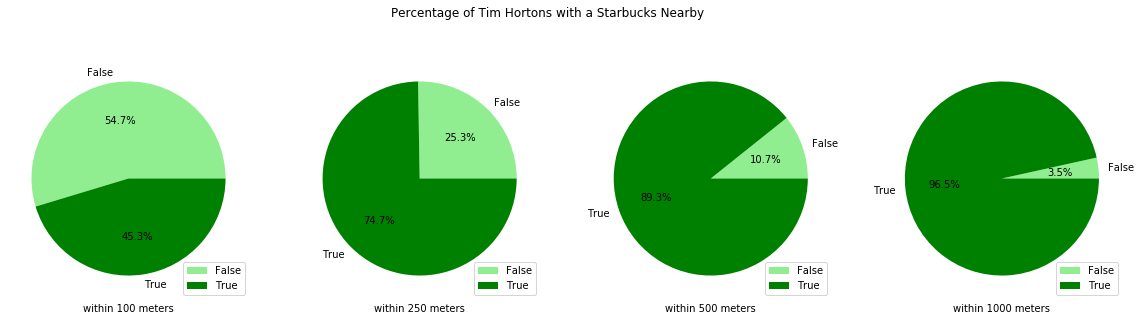

In [33]:
figure,axes=plt.subplots(nrows=1,ncols=4,figsize=(20,5))
colors = ['lightgreen', 'green']
labels = ['False', 'True']

pie1=axes[0].pie(tim_100, autopct='%1.1f%%', colors = colors, labels = labels)
pie2=axes[1].pie(tim_250, autopct='%1.1f%%', colors = colors, labels = labels)
pie3=axes[2].pie(tim_500, autopct='%1.1f%%', colors = colors, labels = labels)
pie4=axes[3].pie(tim_1000, autopct='%1.1f%%', colors = colors, labels = labels)

axes[0].set_xlabel('within 100 meters')
axes[1].set_xlabel('within 250 meters')
axes[2].set_xlabel('within 500 meters')
axes[3].set_xlabel('within 1000 meters')

axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')
axes[2].legend(loc='lower right')
axes[3].legend(loc='lower right')

figure.suptitle('Percentage of Tim Hortons with a Starbucks Nearby')
plt.show()

We were surprised to discover that **more than 45% of Tim Horton's have a Starbucks within 100 meters, nearly 75% of Tim Horton's have a Starbucks within 250 meters, nearly 90% have a Starbucks within 500 meters, and even 96.5% percent have a Starbucks within 1000 meters**. Thus, we could draw the conclusion that for a large amount of Tim Horton's, there is a Starbucks nearby. (**Question 3.4** continue)

**Secondly**, we calculated the distance between every Tim Horton's and the nearest Starbucks and plotted the distribution of the distances in the following boxplot.

In [34]:
def distance(lng1,lat1,lng2,lat2):
    lng1, lat1, lng2, lat2 = map(radians, [float(lng1), float(lat1), float(lng2), float(lat2)])  # 经纬度转换成弧度
    dlon = lng2 - lng1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    distance = 2 * asin(sqrt(a)) * 6371 * 1000  # 地球平均半径，6371km
#     distance = round(distance, 0)
    return distance

In [35]:
tims.loc[:, 'distance'] = 120000
for i in range(0, len(tims)):
    lng1 = tims.longitude[i]
    lat1 = tims.latitude[i]
    for j in range(0, len(stars)):
        lng2 = stars.longitude[j]
        lat2 = stars.latitude[j]
        d = distance(lng1, lat1, lng2, lat2)
        if d < tims.distance[i]:
            tims.loc[i, 'distance'] = d

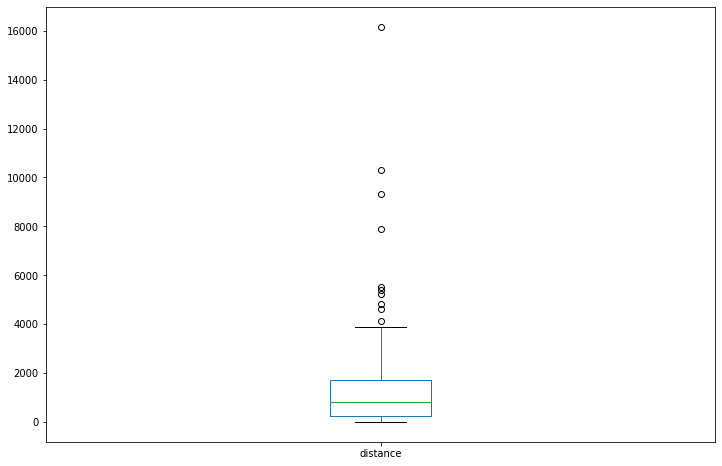

In [113]:
plt.figure(figsize=(12, 8))
tims.distance.plot.box()
plt.show()

From the boxplot, we noticed that there are several outliers in the distance. A common definition for outliers are the values 1.5\*IQR larger than the 75% quantile or 1.5\*IQR less than the 25% quantile. In order to have a clearer insight into the majority of the data, we decided to remove these outliers. 

Then, we drew a histogram of the distribution of the distance from the nearest Starbucks of Tim Hortons in GTA.

In [37]:
d_q1 = tims.distance.quantile(0.25)
d_q3 = tims.distance.quantile(0.75)
d_iqr = d_q3 - d_q1
tims['outliers'] = (tims.distance>d_q3+1.5*d_iqr) | (tims.distance<d_q1-1.5*d_iqr)
tim_distance = tims[tims.outliers==False]

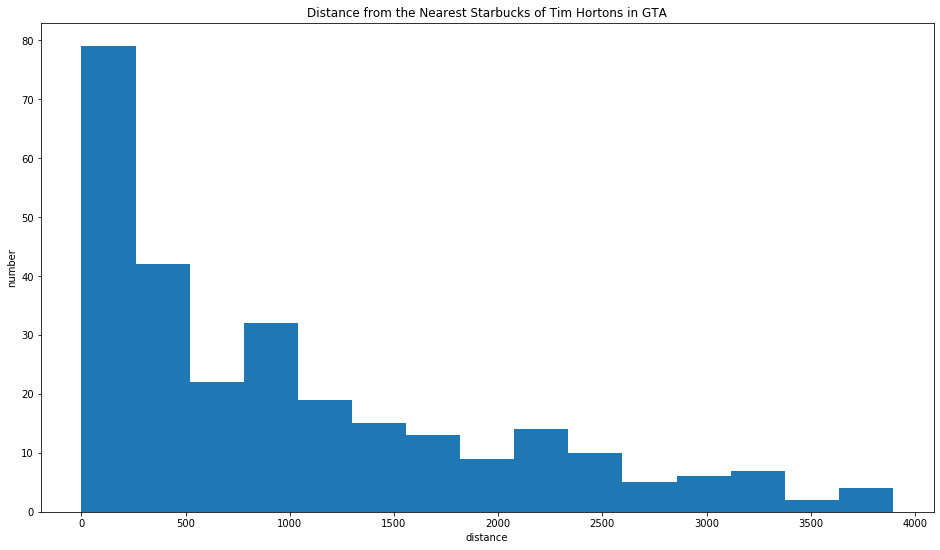

In [46]:
plt.figure(figsize=(16, 9))
plt.hist(tim_distance.distance, 15)
plt.xlabel('distance')
plt.ylabel('number')
plt.title('Distance from the Nearest Starbucks of Tim Hortons in GTA')
plt.show()

From the graph, **the distribution of the distances between establishments of Tim Horton's and Starbucks is unimodel and strongly skewed to right, with a peak i the range between 0 and 250.** It is obvious that the two coffee giants prefer cluster together, possibly because this is the best strategy under the game theory: they are competing for the best locations and they find it most valuable to even keep in the game of market share. (**Question 3.4**)

Probably, we should learn from the experience of these two coffee giants and also choose to clsuter together with them. However, we are also faced with a dilemma that the location chosen by the coffe giants might be better oeverall, but they might also attract away some of our potential customers, considering their large influence. Thus, let's analyse the choices of other coffee chops.

**Thirdly**, similarly, we calculated the proportion of other coffee shops with a Tim Horton's and Starbucks within different distance, using the same strategy as before, and drew the pie charts below.

In [40]:
GTA_cate = GTA.drop('categories', axis=1).join(
    GTA['categories'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('categories'))
coffee = GTA_cate[GTA_cate.categories == 'Coffee & Tea']
coffee.loc[:, 'tim_star'] = (coffee.loc[:,'name'] == 'Tim Hortons') | (coffee.loc[:,'name'] == 'Starbucks')
coffee_other = coffee[coffee.tim_star==False].reset_index().drop(columns = 'index')

In [41]:
coffee_other['100'] = False
coffee_other['250'] = False
coffee_other['500'] = False

def other_near(group, distance):
    for i in range(0, len(coffee_other)):
        lat = coffee_other.latitude[i]
        long = coffee_other.longitude[i]
        s = []
        for j in range(0, len(tim_star)):
            if (tim_star.latitude[j]>=lat-distance) and (tim_star.latitude[j]<=lat+distance):
                s.append(j)
        if len(s) > 0:
            for j in s:
                if (tim_star.longitude[j]<long-distance) or (tim_star.longitude[j]>long+distance):
                    s.remove(j)
        if len(s) > 0:
            coffee_other.loc[i,group] = True
    other = coffee_other.groupby(group).count().longitude
    return other

other_500 = other_near('500', 0.0045)
other_250 = other_near('250', 0.0023)
other_100 = other_near('100', 0.0009)

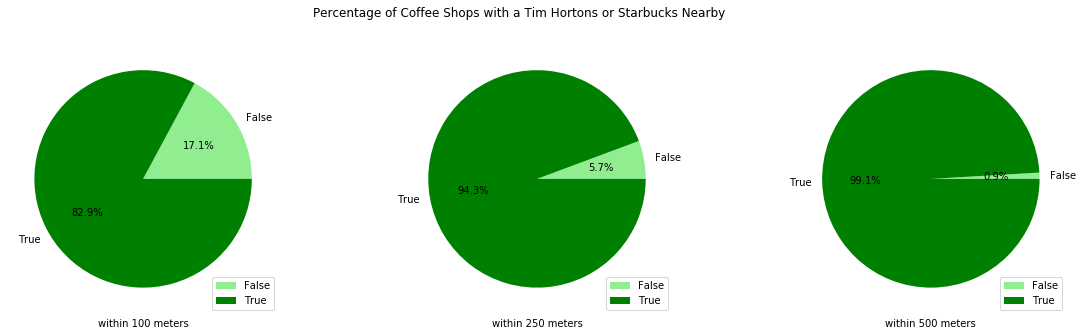

In [42]:
figure,axes=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
colors = ['lightgreen', 'green']
labels = ['False', 'True']
pie1=axes[0].pie(other_100, autopct='%1.1f%%', colors = colors, labels = labels)
pie2=axes[1].pie(other_250, autopct='%1.1f%%', colors = colors, labels = labels)
pie3=axes[2].pie(other_500, autopct='%1.1f%%', colors = colors, labels = labels)
axes[0].set_xlabel('within 100 meters')
axes[1].set_xlabel('within 250 meters')
axes[2].set_xlabel('within 500 meters')
axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')
axes[2].legend(loc='lower right')
figure.suptitle('Percentage of Coffee Shops with a Tim Hortons or Starbucks Nearby')
plt.show()

The pie charts demonstrate that **more than 80% of coffee shops have a Tim Horton's or Starbucks within 100 meters, nearly 95% of them have a Tim Horton's or Starbucks within 250 meters, and even 99% of them have a Tim Horton's or Starbucks within 500 meters.** Thus, we could conclude that most of the coffee shops choose to locate near these two coffee giants. Probably, the sole coffee shop owners believe that the decision-making team of Tim Horton's and Starbucks are able to find the best location, so they just follow them when choosing shop fronts.

Therefore, we could simply follow this pattern and choose a location near a Tim Horton's or Starbucks as well.

## How to Start the Coffee Business?

After determing where to start the coffee business, it is time for deciding the business strategy and production designs.  In order to learn from the experience of others and make better decision, we would analyse the characteristics of some successful coffee businesses.

### Definition of Successful Coffee Business.

We noticed that in the `business` dataset, there are two evaluation indexes for business: `stars` and `review_count`. In order to know how we can derive a definition of success from this two indexes, we analysed the relationship between `stars` and `review_count`.

First, we extracted the two indexes from the original dataframe to a new dataframe `df_star` and grouped it by `stars`. Then, we used the `describe()` to have a glimpse of the distribution of the data.

In [47]:
df_star = df[['review_count', 'stars']]
star_groups = df_star.groupby('stars')
star_groups.describe()

review_count                                                     
             count       mean         std  min  25%   50%   75%     max
stars                                                                  
1.0         4874.0   5.815552   12.027597  3.0  3.0   3.0   5.0   392.0
1.5         4976.0  15.596664   44.308352  3.0  3.0   7.0  14.0  1258.0
2.0        11426.0  15.108874   31.761224  3.0  4.0   7.0  15.0  1658.0
2.5        18842.0  20.911581   75.269496  3.0  3.0   7.0  18.0  4117.0
3.0        25996.0  30.857286   90.686141  3.0  5.0  11.0  28.0  3944.0
3.5        35008.0  40.681130  112.376081  3.0  5.0  11.0  36.0  6708.0
4.0        35969.0  56.523228  170.368055  3.0  5.0  13.0  43.0  8348.0
4.5        27301.0  43.444453  126.271964  3.0  6.0  12.0  33.0  5075.0
5.0        28216.0  12.113942   28.907074  3.0  3.0   5.0  10.0  1936.0

From the dataframe above, we noticed that, for each level of stars, even the third quantile is still very small when comparing to the max number of reviews, which means there are extreme outliers in each level of stars. In order to have better visualizations, we choose to analyse the values affected by the outliers and not affected separately.

**First**, since both the mean value and the max value are strongly affected by outliers, we drew the bar plots below for the mean number of reviews and max number of reviews corresponding to each level of stars.

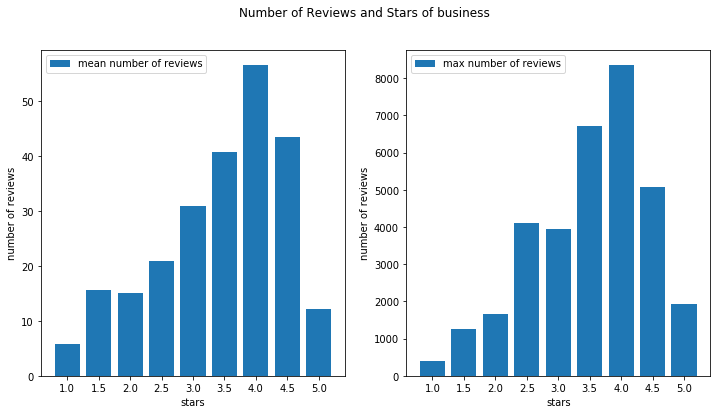

In [48]:
x = np.arange(len(star_groups))

figure,ax=plt.subplots(1,2, figsize=(12,6))

# the first barplot: mean
ax[0].bar(x, star_groups.mean().review_count, label='mean number of reviews', tick_label=star_groups.mean().index)
ax[0].legend()
ax[0].set_xlabel('stars')
ax[0].set_ylabel('number of reviews')

# the first barplot: mean
ax[1].bar(x, star_groups.max().review_count, label='max number of reviews', tick_label=star_groups.max().index)
ax[1].legend()
ax[1].set_xlabel('stars')
ax[1].set_ylabel('number of reviews')

figure.suptitle('Number of Reviews and Stars of business')
plt.show()

From the graph above, we noticed that **the distribution of both the mean and max number of reviews are unimodel and skewed to left, with a peak at round 4.0 stars**. (**Question 2.4**)

**Second**, we inverstigated the first, second, and third quantiles of number of reviews of each level of stars, which would not be affected by the extreme outliers. We drew the line chart for the three quantiles below.

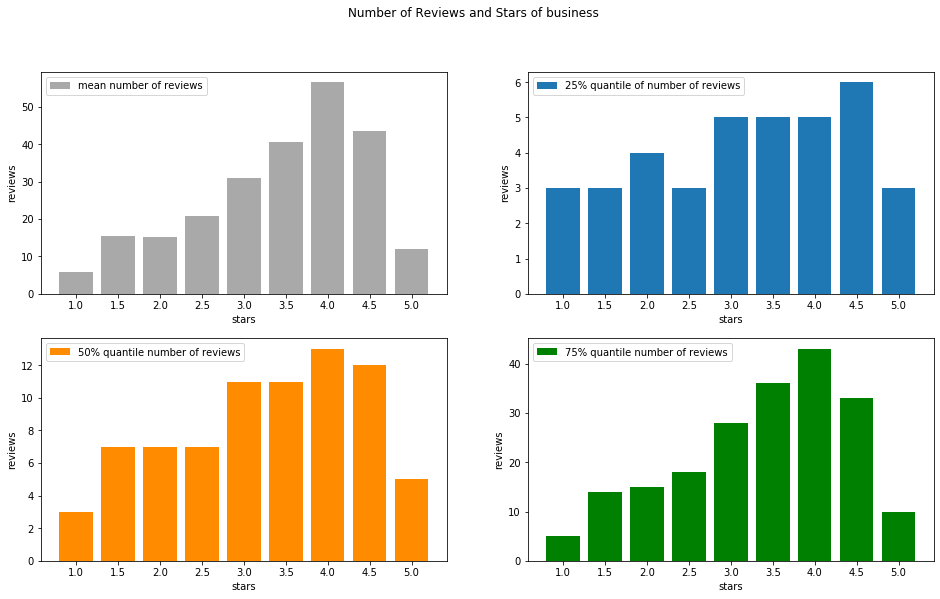

In [49]:
x = np.arange(len(star_groups))

figure,ax=plt.subplots(2,2, figsize=(16,9))

# the first barplot: mean
ax[0][0].bar(x, star_groups.mean().review_count, label='mean number of reviews', color='darkgrey', 
             tick_label=star_groups.mean().index)
ax[0][0].legend()
ax[0][0].set_xlabel('stars')
ax[0][0].set_ylabel('reviews')

# the first barplot: mean
ax[0][1].bar(x, star_groups.quantile(0.25).review_count, label='25% quantile of number of reviews', tick_label=star_groups.quantile(0.25).index)
ax[0][1].legend()
ax[0][1].set_xlabel('stars')
ax[0][1].set_ylabel('reviews')

# the first barplot: mean
ax[1][0].bar(x, star_groups.quantile(0.5).review_count, label='50% quantile number of reviews', color='darkorange', 
             tick_label=star_groups.quantile(0.5).index)
ax[1][0].legend()
ax[1][0].set_xlabel('stars')
ax[1][0].set_ylabel('reviews')

# the first barplot: mean
ax[1][1].bar(x, star_groups.quantile(0.75).review_count, label='75% quantile number of reviews', color='green', 
             tick_label=star_groups.quantile(0.75).index)
ax[1][1].legend()
ax[1][1].set_xlabel('stars')
ax[1][1].set_ylabel('reviews')


figure.suptitle('Number of Reviews and Stars of business')
plt.show()


x = np.arange(len(GTA_cate_count.head(10)))

# plt.barh(x, percent_gta, color=colors0, height=height, label='percentage in the GTA')
# plt.barh(x+height, percent_all, color=colors1, height=height, label='percentage overall', tick_label=cate_gta)

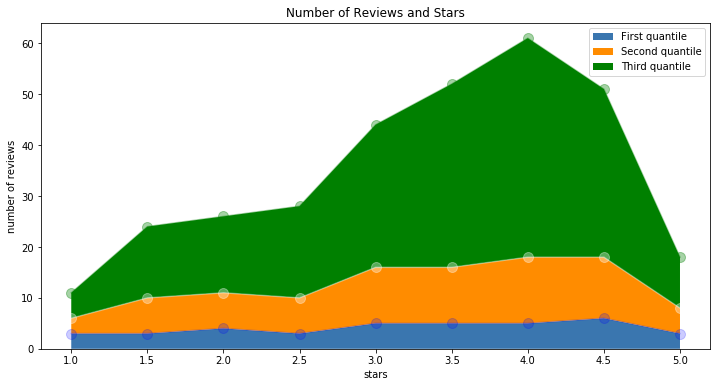

In [50]:
# data
x = np.array(star_groups.mean().index)  # x坐标
y1 = np.array(star_groups.quantile(0.25).review_count) 
y2 = np.array(star_groups.quantile(0.5).review_count)
y3 = np.array(star_groups.quantile(0.75).review_count)
labels = ["First quantile ", "Second quantile", "Third quantile"] 

# figure
fig =plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)

# plot
colors = ['#3A76AF', 'darkorange', 'green']
ax.stackplot(x, y1, y2, y3, labels=labels, colors = colors)
# add points
ax.plot(x,y1,'bo-',markersize=10,alpha=0.2)
ax.plot(x,y1+y2,'wo-',markersize=10,alpha=0.35)
ax.plot(x,y1+y2+y3,'go-',markersize=10,alpha=0.35)

# setting
ax.legend(loc='best')
plt.title('Number of Reviews and Stars')
plt.xlabel('stars')
plt.ylabel('number of reviews')

plt.show()

From the graph above, we discovered that the distributions of the three quantiles of the number of reviews are also unimodel and skewed to left. The peak of both the second and third quantiles are at 4.0 stars while the first quantile is slightly larger at 4.5 stars. 

This result is pretty similar to that of the mean and max values. Thus, either considering the influence of the extreme outliers or not, **the businesses with around 4 stars tend to have the largest number of reviews**. In addition, **the number of reviews is increasing from 1 stars to 4 stars, but the number of reviews of business with 5 stars is small**.

Therefore, **generally more reviews would lead to high stars**. However it is always difficult to be perfect, so with increasing number of reviews, it is hard to maintain 5 stars, and the businesses with 5 stars are usually shops with a small amount of good reviews. As a result, in later analysis, we would define businesses with 4 stars to be successful.  (**Question 2.4**)

### Attributes to Include

During this process of deciding business strategy, we have to determine whether to include certain attributes, such as bike parking spaces, outdoor seatings, and takeouts, in our business. There are numerous attributes we have to consider. In this report, I would take bikeparking spaces as an example. (**Question 2.3**)

**First**, extrated the businesses with bikeparking to a new dataframe `BikeParking` and splited different categories in a single row to multiple rows. Then, we merged the total number of each category in `Category_count` to `BikeParking_category` and calculted the percentage with bike parking in each category.

Then, we visulized our data in the bar plots below. The bar marked red represents the category coffee & tea.

In [51]:
# extract business with BikeParking
BikeParking = df[df.BikeParking==True][['categories']]
BikeParking = BikeParking.drop('categories', axis=1).join(
    BikeParking['categories'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('categories')).reset_index()

In [52]:
# establishments with bikeparking
BikeParking_category = BikeParking.groupby('categories').count().sort_values('index', ascending=False)
BikeParking_category.columns = ['bike_park']
BikeParking_category = pd.merge(BikeParking_category.reset_index(), category_count.reset_index(), how='outer', on='categories')
BikeParking_category.percent = BikeParking_category.bike_park / BikeParking_category.num
BikeParking_category = BikeParking_category.sort_values('bike_park', ascending=False)

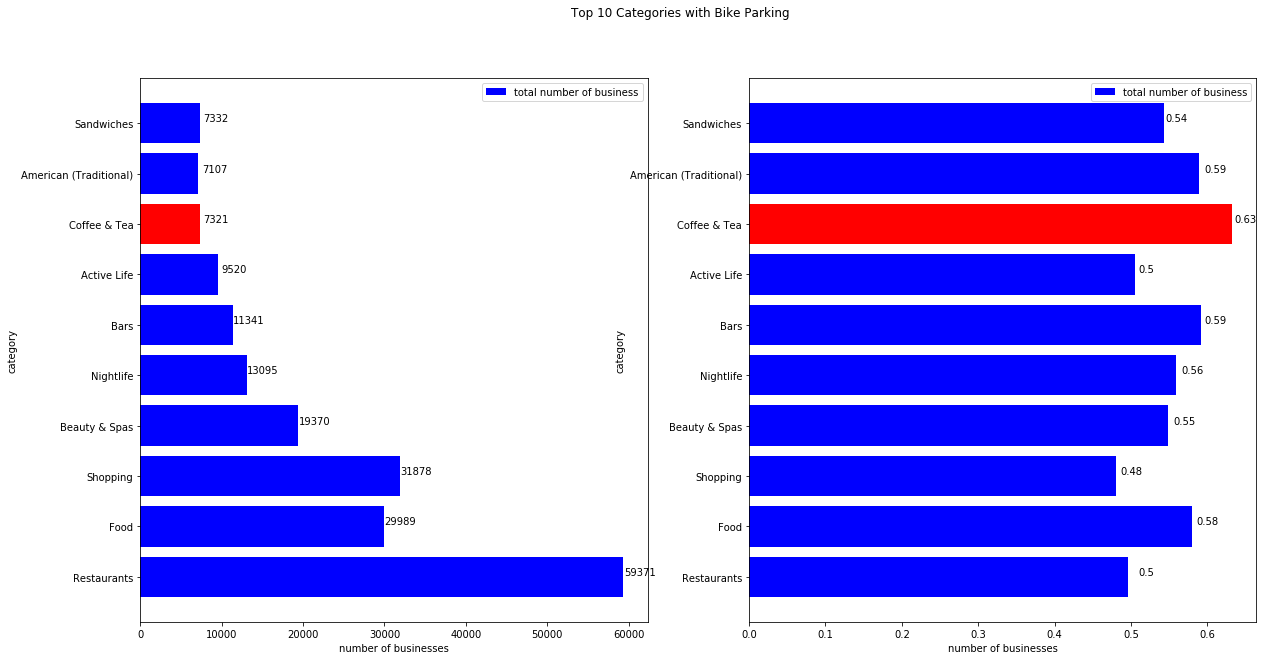

In [57]:
colors = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'b']
x = np.arange(10)
figure,ax=plt.subplots(1,2, figsize=(20,10))

# the first barplot: mean
ax[0].barh(x, BikeParking_category.head(10).num, color=colors, label='total number of business', tick_label=BikeParking_category.head(10).categories)
ax[0].legend(loc='best')
ax[0].set_xlabel('number of businesses')
ax[0].set_ylabel('category')
for a,b in zip(x, BikeParking_category.head(10).num):
    ax[0].text(b+2000, a, b, ha='center', va='bottom')

# the first barplot: mean
ax[1].barh(x, BikeParking_category.head(10).percent, color=colors, label='total number of business', tick_label=BikeParking_category.head(10).categories)
ax[1].legend(loc='best')
ax[1].set_xlabel('number of businesses')
ax[1].set_ylabel('category')
for a,b in zip(x, BikeParking_category.head(10).percent):
    b = round(b, 2)
    ax[1].text(b+0.02, a, b, ha='center', va='bottom')

figure.suptitle('Top 10 Categories with Bike Parking')
plt.show()

The bar plots above demonstrated that **the category restaurants has the largest amount of businesses with bike parking and followed by food, shopping, and beauty & Spas**. Also, we noticed that **the category coffee & tea is one of the top 10 categories with largest number of businesses**. Moreoever, **among the top 10 categories, coffee & tea has the largest percentage of businesses with bike parking**. (**Question 2.3**)

Thus, for coffee shops, over all, bike parking spaces might be useful. However, in order to succeed, we would take a deeper insight into the successful examples.

**Second**, we extracted the businesses of the category coffee & tea to a new dataframe `coffee_tea`. Also, since we define the business with 4 stars ratings to be successful, we drew the pie charts below for the percentage of businesses with bike parking in the category coffe & tea overall and with 4 stars rating.

In [79]:
rows = []
for i in range(0, len(GTA)):
    if GTA.categories[i] != None:
        if 'Coffee & Tea' in GTA.categories[i]:
            rows.append(i)
coffee_tea = GTA.loc[rows]

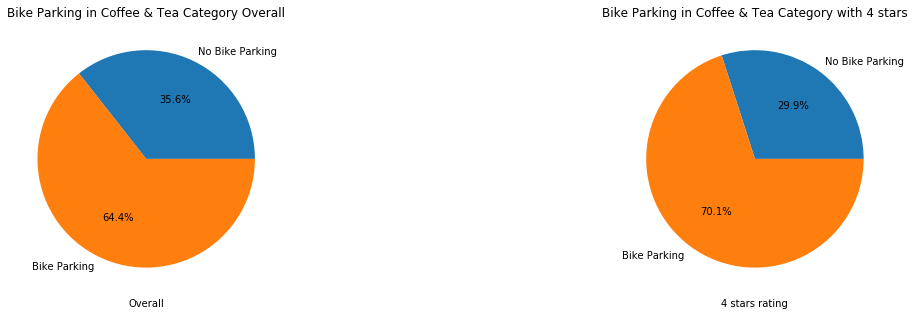

In [85]:
labels = ['No Bike Parking', 'Bike Parking']
x1 = coffee_tea.groupby('BikeParking').count().business_id
x2 = coffee_tea[coffee_tea.stars == 4.0].groupby('BikeParking').count().business_id

figure,axes=plt.subplots(nrows=1,ncols=2,figsize=(20,5))

pie1=axes[0].pie(x1, autopct='%1.1f%%', labels=labels)
pie2=axes[1].pie(x2, autopct='%1.1f%%', labels=labels)
axes[0].set_xlabel('Overall')
axes[1].set_xlabel('4 stars rating')
axes[0].set_title('Bike Parking in Coffee & Tea Category Overall')
axes[1].set_title('Bike Parking in Coffee & Tea Category with 4 stars')

plt.show()

From the pie charts above, we discovered that  **64.4% of businesses of category coffee & tea have bike parking, while among the businesses with 4 stars ratings in this category, 70% of them have bike parking**. 

The rate in bike parking is slightly larger, so probably including bike parking in the attributes of our coffee business is a wise choice.

### Learning From Tim Horton's and Starbucks.

In addition to the coffee businesses with 4 stars rating, the characteristics for Tim Horton's and Starbucks to become coffee giants are also meaningful for us. This time, we would make use of the reviews of these two franchises. (**Question 4.2**)

**First**, we added two new columns `tim` and `star` to the `GTA_review` dataframe, indicating whether the review is for Tim Horton's or Starbucks.  Then, we extracted the text from the reviews of the two franchises and stored them in `tims_reviews` and `stars_reviews` respectively.

Also, we created a list of meaningless words `stopwords` (partially copied from https://programminghistorian.org/en/lessons/counting-frequencies#frequencies and modified by myself), then we count the number of appearances of each words in the text of reviews, ignoring the words in `stopwords`. We saved the word counts in the reviews for Tim Horton's and Starbucks in `tims_word` and `stars_word` respectively, and created a wordcloud for each of them.

In [87]:
GTA_reviews.loc[:,'tim'] = False
rows = GTA_reviews['business_id'].isin(tims.business_id)
GTA_reviews.loc[rows, 'tim'] = True
tims_reviews = GTA_reviews.loc[GTA_reviews.tim == True].reset_index().drop(columns = 'index')

GTA_reviews.loc[:,'star'] = False
rows = GTA_reviews['business_id'].isin(stars.business_id)
GTA_reviews.loc[rows, 'star'] = True
stars_reviews = GTA_reviews.loc[GTA_reviews.star == True].reset_index().drop(columns = 'index')

In [90]:
stopwords = ['a', 'about', 'above', 'across', 'after', 'afterwards']
stopwords += ['again', 'against', 'all', 'almost', 'alone', 'along']
stopwords += ['already', 'also', 'although', 'always', 'am', 'among']
stopwords += ['amongst', 'amoungst', 'amount', 'an', 'and', 'another']
stopwords += ['any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere']
stopwords += ['are', 'around', 'as', 'at', 'back', 'be', 'became']
stopwords += ['because', 'become', 'becomes', 'becoming', 'been']
stopwords += ['before', 'beforehand', 'behind', 'being', 'below']
stopwords += ['beside', 'besides', 'between', 'beyond', 'bill', 'both']
stopwords += ['bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant']
stopwords += ['co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de']
stopwords += ['describe', 'detail', 'did', 'do', 'done', 'down', 'due', "don't"]
stopwords += ['during', 'each', 'eg', 'eight', 'either', 'eleven', 'else']
stopwords += ['elsewhere', 'empty', 'enough', 'etc', 'even', 'ever']
stopwords += ['every', 'everyone', 'everything', 'everywhere', 'except']
stopwords += ['few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first']
stopwords += ['five', 'for', 'former', 'formerly', 'forty', 'found']
stopwords += ['four', 'from', 'front', 'full', 'further', 'get', 'give']
stopwords += ['go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her']
stopwords += ['here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers']
stopwords += ['herself', 'him', 'himself', 'his', 'how', 'however']
stopwords += ['hundred', 'I', 'i', 'I\'m', 'I\'ve', 'ie', 'if', 'in', 'inc', 'indeed']
stopwords += ['interest', 'into', 'is', 'it', 'It', 'its', 'it\'s', 'itself', 'just', 'keep']
stopwords += ['last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made']
stopwords += ['many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine']
stopwords += ['more', 'moreover', 'most', 'mostly', 'move', 'much']
stopwords += ['must', 'my', 'myself', 'name', 'namely', 'neither', 'never']
stopwords += ['nevertheless', 'next', 'nine', 'no', 'nobody', 'none']
stopwords += ['noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of']
stopwords += ['off', 'often', 'on','once', 'one', 'only', 'onto', 'or']
stopwords += ['other', 'others', 'otherwise', 'our', 'ours', 'ourselves']
stopwords += ['out', 'over', 'own', 'part', 'per', 'perhaps', 'please']
stopwords += ['put', 'rather', 're', 's', 'same', 'see', 'seem', 'seemed']
stopwords += ['seeming', 'seems', 'serious', 'several', 'she', 'should']
stopwords += ['show', 'side', 'since', 'sincere', 'six', 'sixty', 'so']
stopwords += ['some', 'somehow', 'someone', 'something', 'sometime']
stopwords += ['sometimes', 'somewhere', 'still', 'such', 'system', 'take']
stopwords += ['ten', 'than', 'that', 'the', 'The', 'There', 'their', 'They', 'them', 'themselves']
stopwords += ['then', 'thence', 'there', 'thereafter', 'thereby']
stopwords += ['therefore', 'therein', 'thereupon', 'these', 'they']
stopwords += ['thick', 'thin', 'third', 'this', 'This', 'those', 'though', 'three']
stopwords += ['three', 'through', 'throughout', 'thru', 'thus', 'to']
stopwords += ['together', 'too', 'top', 'toward', 'towards', 'twelve']
stopwords += ['twenty', 'two', 'un', 'under', 'until', 'up', 'upon']
stopwords += ['us', 'very', 'via', 'was', 'we', 'well', 'were', 'what']
stopwords += ['whatever', 'when', 'whence', 'whenever', 'where']
stopwords += ['whereafter', 'whereas', 'whereby', 'wherein', 'whereupon']
stopwords += ['wherever', 'whether', 'which', 'while', 'whither', 'who']
stopwords += ['whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with']
stopwords += ['within', 'without', 'would', 'yet', 'you', 'your']
stopwords += ['yours', 'yourself', 'yourselves']
stopwords += ['Tim', 'Hortons', 'Starbucks']

In [91]:
def word_count(reviews):
    counts = {}
    for i in range(0, len(reviews)):
        for ch in '!"@#$%^&*()+,-./:;<=>?@[\\]_`~{|}':
            reviews.loc[i] = reviews[i].replace(ch, ' ')
        txtArr = reviews.loc[i].split()
        for word in txtArr:
            if (word in stopwords) == False:
                counts[word] = counts.get(word, 0) + 1
    word_count = pd.DataFrame(list(counts))
    word_count.columns = ['word']
    for i in range(0, len(word_count)):
        word_count.loc[i, 'num'] = counts[word_count.word[i]]
    return word_count

In [92]:
tims_word = word_count(tims_reviews.text).sort_values('num', ascending=False).reset_index().drop(columns = 'index')
tims_word.columns = ['word', 'tims_num']

In [93]:
stars_word = word_count(stars_reviews.text).sort_values('num', ascending=False).reset_index().drop(columns = 'index')
stars_word.columns = ['word', 'stars_num']

In [874]:
word_list = []
for i in range(0, len(tims_word)):
    word_list.append((tims_word.word[i], tims_word.tims_num[i]))
cloud = (
    WordCloud()
    .add("", word_list)
    .set_global_opts(title_opts=opts.TitleOpts(title="Reviews of Tim Hortons"))
    )
cloud.render_notebook()

This is the wordcoud for the reviews of Tim Hortons. It gives us an overall gimpse of the text in the reviews. 

In [875]:
word_list = []
for i in range(0, len(stars_word)):
    word_list.append((stars_word.word[i], stars_word.stars_num[i]))
cloud = (
    WordCloud()
    .add("", word_list)
    .set_global_opts(title_opts=opts.TitleOpts(title="Reviews of Starbucks"))
    )
cloud.render_notebook()

This is the wordcoud for the reviews of Tim Hortons. It gives us an overall gimpse of the text in the reviews. 

From the two word clouds, it seems that **users tend to use similar languages in the reviews for Tim Horton's and Starbucks**. More specifically, **in the reviews of both franchises, words like 'location' and 'coffee' are repeatedly emphasized**.

**Next**, let us quantify this observtion in the bar plots below. The bar plots show the 10 most frequent words in the reviews of Tim Hortons and Starbucks respectively.

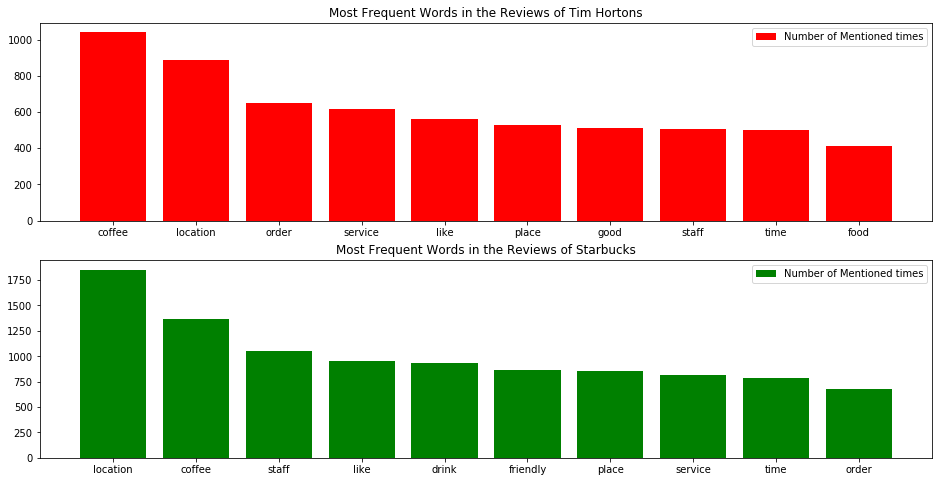

In [876]:
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(16,8))
labels = ['outliers', 'Nonoutliers']
x = np.arange(10)

axes[0].bar(x, tims_word.head(10).tims_num, label='Number of Mentioned times', color='r', tick_label=tims_word.head(10).word)
axes[0].legend(loc='best')
axes[0].set_title('Most Frequent Words in the Reviews of Tim Hortons')

axes[1].bar(x, stars_word.head(10).stars_num, label='Number of Mentioned times', color='green', tick_label=stars_word.head(10).word)
axes[1].legend(loc='best')
axes[1].set_title('Most Frequent Words in the Reviews of Starbucks')

plt.show()

The barplots demostrated that **the words used in the reviews of the two franchises are pretty similar**. The words 'coffee', 'location', 'order', 'service', 'like', 'place', 'staff', 'time' are mentioned very frequently in the reviews of both franchises, which means these qualities are rather important for all coffee franchises. 

In the reviews of Tim Hortons, the word 'good' is mentioned frequently, while in the reviews of Starbucks, the word 'friendly' is mentioned frequently. Probably, the staff of Tim Horton's are generally good, but the staff in Starbucks are rather friendly. 

Also, 'food' is mentioned frequently in the reviews of Tim Horton's while 'drinks' is mentioned frequently in the reviews of Starbucks. Probably, Tim Horton's is better at making food and Starbucks do better in drinks.

**In addition**, we are also interested in the reviews written by the subset of users who reviewed both establishments. Thus, we extracted the list of `user_id` in both `tims_reviews` and `stars_reviews` and counted the words they mentioned in their reviews. (**Question 4.2**)

In [105]:
tims_user = tims_reviews.user_id.unique()
stars_user = stars_reviews.user_id.unique()
users = []
total = []
for user in tims_user:
    if user in stars_user:
        users.append(user)

In [108]:
tims_reviews['total'] = False
for i in range(0, len(tims_reviews)):
    if tims_reviews.user_id[i] in users:
        tims_reviews.loc[i, 'total'] = True 

stars_reviews['total'] = False
for i in range(0, len(stars_reviews)):
    if stars_reviews.user_id[i] in users:
        stars_reviews.loc[i, 'total'] = True  

tims_total = tims_reviews[tims_reviews.total==True].reset_index()
stars_total = stars_reviews[stars_reviews.total==True].reset_index()

In [109]:
tims_total_word = word_count(tims_total.text).sort_values('num', ascending=False).reset_index().drop(columns = 'index')
tims_total_word.columns = ['word', 'tims_num']

In [110]:
stars_total_word = word_count(stars_total.text).sort_values('num', ascending=False).reset_index().drop(columns = 'index')
stars_total_word.columns = ['word', 'stars_num']

In [111]:
total_word = pd.merge(tims_total_word, stars_total_word, how = 'outer', on = 'word')
total_word['num'] = total_word.tims_num + total_word.stars_num
total_word = total_word.sort_values('num', ascending = False).reset_index().drop(columns = 'index')
total_word.head(10)

word  tims_num  stars_num     num
0  location     419.0      686.0  1105.0
1    coffee     340.0      468.0   808.0
2      like     188.0      363.0   551.0
3     staff     187.0      325.0   512.0
4     place     175.0      319.0   494.0
5   service     204.0      255.0   459.0
6      good     181.0      229.0   410.0
7      time     159.0      246.0   405.0
8    people     158.0      247.0   405.0
9     order     194.0      201.0   395.0

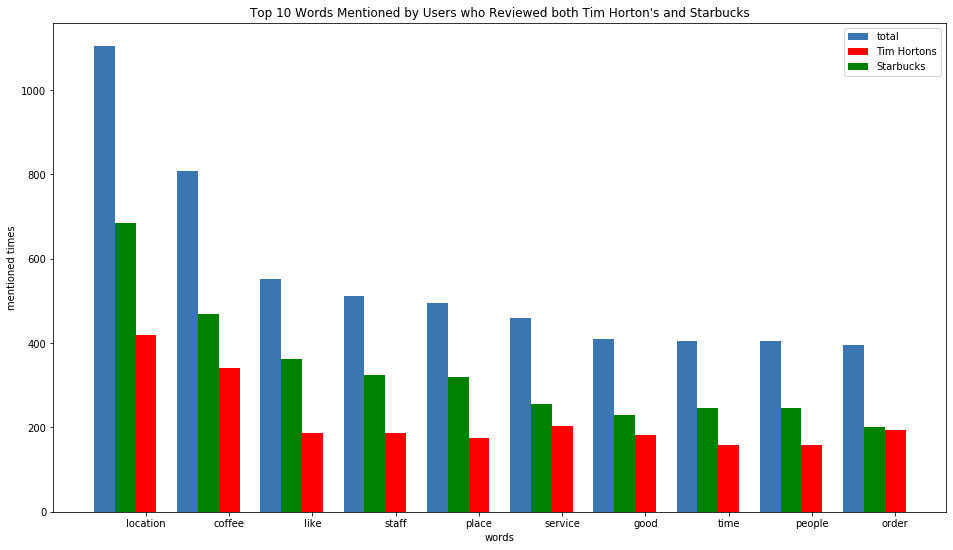

In [115]:
# colors0 = ['r', 'r', 'b', 'b', 'b', 'r', 'r', 'b', 'b', 'b']
# colors1 = ['lightcoral', 'lightcoral', 'cornflowerblue', 'cornflowerblue', 'cornflowerblue', 'lightcoral', 'lightcoral', 'cornflowerblue', 'cornflowerblue', 'cornflowerblue']
height = 0.25
x = np.arange(10)

plt.figure(figsize=(16, 9))
plt.bar(x, total_word.head(10).num,  color='#3A76AF', width=height, label='total')
plt.bar(x+2*height, total_word.head(10).tims_num, color='r', width=height, label='Tim Hortons', tick_label=total_word.head(10).word)
plt.bar(x+height, total_word.head(10).stars_num, color='green', width=height, label='Starbucks')
plt.legend(loc='best')
plt.ylabel('mentioned times')
plt.xlabel('words')
plt.title("Top 10 Words Mentioned by Users who Reviewed both Tim Horton's and Starbucks")

plt.show()

The bar plot above demonstrated the top 10 words mentioned by the subset of users who reviewed both establishments. We discovered that **the reviews tends to comment more for Starbucks, comparing to the Tim Horton's.** 

Also, we reproduced our procedure earlier, but this time we only used the data mentioned by the subset of users who reviewed both establishments.

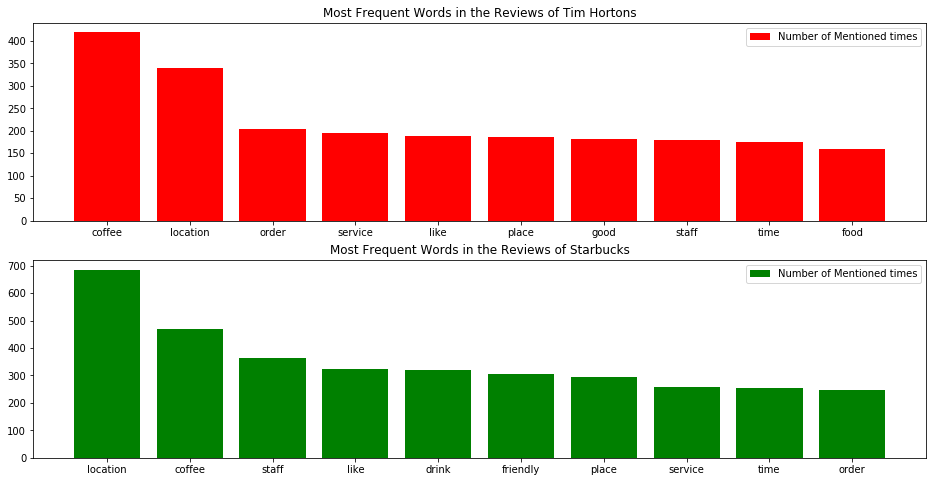

In [116]:
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(16,8))
labels = ['outliers', 'Nonoutliers']
x = np.arange(10)

axes[0].bar(x, tims_total_word.head(10).tims_num, label='Number of Mentioned times', color='r', tick_label=tims_word.head(10).word)
axes[0].legend(loc='best')
axes[0].set_title('Most Frequent Words in the Reviews of Tim Hortons')

axes[1].bar(x, stars_total_word.head(10).stars_num, label='Number of Mentioned times', color='green', tick_label=stars_word.head(10).word)
axes[1].legend(loc='best')
axes[1].set_title('Most Frequent Words in the Reviews of Starbucks')

plt.show()

It is not surprising that, the results are almost the same as that of all users. **The reviewers tend to use similar language in the reviews of both Starbucks and Tim Hortons.** 

The words 'coffee', 'location', 'order', 'service', 'like', 'place', 'staff', 'time' are mentioned very frequently in the reviews of both franchises.

In the reviews of Tim Hortons, the word 'good' is mentioned frequently, while in the reviews of Starbucks, the word 'friendly' is mentioned frequently. Also, 'food' is mentioned frequently in the reviews of Tim Horton's while 'drinks' is mentioned frequently in the reviews of Starbucks. 

Therefore, in our coffee shop, we have to pay more attention to the quality of coffee, the service of the staff, and the waiting time.

## Considerations
1. We discovered that a small group of users is responsible for most reviews. (See the pie charts below) (**Question 4.1**)

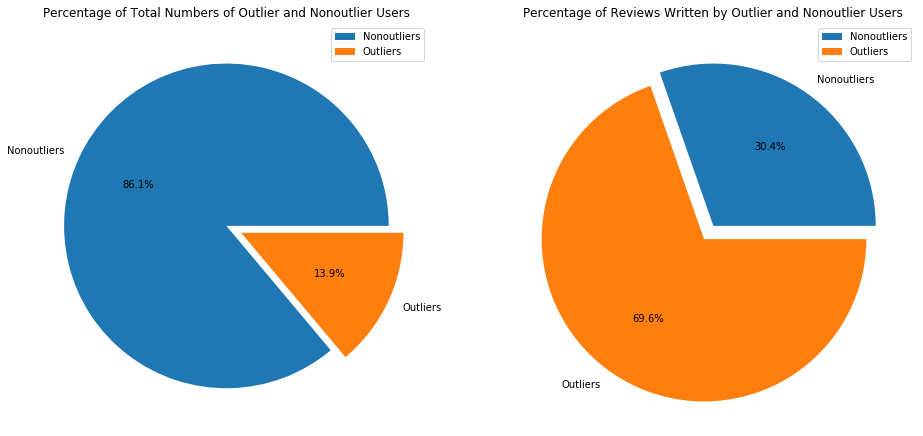

In [890]:
reviews_count = GTA_reviews.groupby('user_id').count().sort_values('review_id', ascending=False)[['review_id']]
reviews_count.columns = ['num']

q1 = reviews_count.num.quantile(0.25)
q3 = reviews_count.num.quantile(0.75)
iqr = q3 - q1
reviews_count.loc[:, 'outliers'] = (reviews_count.num > q3+1.5*iqr) | (reviews_count.num < q1-1.5*iqr)
reviews_outliers = reviews_count.groupby('outliers')

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(16,9))
labels = ['Nonoutliers', 'Outliers']

axes[0].pie(reviews_outliers.count().num, labels = labels, autopct='%1.1f%%', explode=[0, 0.1])
axes[0].legend(loc='best')
axes[0].set_title('Percentage of Total Numbers of Outlier and Nonoutlier Users')

axes[1].pie(reviews_outliers.sum().num, labels = labels, autopct='%1.1f%%', explode=[0, 0.1])
axes[1].legend(loc='best')
axes[1].set_title('Percentage of Reviews Written by Outlier and Nonoutlier Users')

plt.show()

We separated the ourliers in the number of reviews written by each users. The outliers only account for less than 14% of reviewers, but they account for nearly 70% of the reviews. Thus, the reviews might only represent the opinions from this subset of customers and might not be representative for all customers.

2. We are not able to automatically determine whether the reviewers were paid for writting reviews.

In [806]:
GTA[GTA.stars == 5].sort_values('review_count', ascending=False).head()

business_id                                name  \
23337  egLYFnycp8ktxMCvilFdLw                      Passport Photo   
10824  g6AFW-zY0wDvBl9U82g4zg                       Baretto Caffe   
3688   J9vAdD2dCpFuGsxPIn184w    New Orleans Seafood & Steakhouse   
29070  WuH8ncHXNBvAna7t-BX7xg  Step Up Massage & Rehab - Adelaide   
30086  8vmuInQkTrRgCxlxo5y_mw                     Famik Esthetics   

                                address     city state postal_code   latitude  \
23337     327B Spadina Avenue, Unit 203  Toronto    ON     M5T 2E9  43.654537   
10824               1262 Don Mills Road  Toronto    ON     M3B 2W7  43.744703   
3688                  267 Scarlett Road  Toronto    ON     M6N 4L1  43.677744   
29070  218 Adelaide Street W, Suite 200  Toronto    ON     M5H 1W7  43.648681   
30086                                    Markham    ON         L3S  43.850933   

       longitude  stars  review_count  is_open  \
23337 -79.398380    5.0           272        1   
10824 -79.346468    5.0           267        1   
3688  -79.506248    5.0            90        1   
29070 -79.387424    5.0            84        1   
30086 -79.262029    5.0            81        1   

                                              attributes  \
23337  {'BikeParking': 'True', 'BusinessParking': '{'...   
10824  {'Ambience': '{'romantic': False, 'intimate': ...   
3688   {'GoodForMeal': '{'dessert': False, 'latenight...   
29070  {'AcceptsInsurance': 'True', 'BikeParking': 'T...   
30086  {'WheelchairAccessible': 'False', 'ByAppointme...   

                                              categories  \
23337            Shopping, Photography Stores & Services   
10824                        Restaurants, Italian, Cafes   
3688     Steakhouses, Cajun/Creole, Restaurants, Seafood   
29070  Naturopathic/Holistic, Acupuncture, Doctors, H...   
30086     Skin Care, Beauty & Spas, Hair Removal, Waxing   

                                                   hours  modify  \
23337  {'Monday': '10:0-18:0', 'Tuesday': '10:0-18:0'...   False   
10824  {'Monday': '7:30-18:0', 'Tuesday': '7:30-18:0'...   False   
3688   {'Tuesday': '17:0-21:30', 'Wednesday': '17:0-2...   False   
29070  {'Monday': '0:0-0:0', 'Tuesday': '12:0-20:0', ...   False   
30086                                               None   False   

      modified_city  BikeParking   GTA                       modified_name  \
23337       toronto         True  True                      Passport Photo   
10824       toronto         True  True                       Baretto Caffe   
3688        toronto         True  True    New Orleans Seafood & Steakhouse   
29070       toronto         True  True  Step Up Massage & Rehab - Adelaide   
30086       markham         True  True                     Famik Esthetics   

       coffee  
23337   False  
10824   False  
3688    False  
29070   False  
30086   False

For instance, in the dataframe above, we sorted the subset of dataframe of business in the GTA with 5.0 ratings by `review_count`, and discovered that, most of the businesses have fewer than 100 reviews, but the top 2 of them even have more than 200 reviews. How the businesses owners give customers extra incentives to write reviews for them, by extremely impressive service, or simply by money? We never know. (**Question 4.4**)

3. We only analyse based on the yelp dataset. Some franchises who do not use yelp for their business are ignored, so some conclusion might not be concrete.

4. When using the function `fuzzywuzzy`, it is possible that we unified the names of different cities or franchises, and missed some matched pairs.

5. The sample of business in the category coffee & tea with rating 4.0 stars is not big enough, so the conclusion based on this might not be accurate.